# ViTSD Model

Now that we have an optimized model, we can train it with the full data and perform the last test.

# Importing libraries

In [ ]:
import os
import cv2
import math
import torch
import numpy as np
from os import path
import pandas as pd
import torch.nn as nn
from torch import Tensor
from typing import Tuple, List
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# Defining the Model

## Defining the Flatten Layer:

In [ ]:
class Flatten(nn.Module):

    def __init__(self, num_neurons_flatten: int):
      
        """
        
        Constructor for the Flatten module.
        
        Module that flattens the input tensor into a 2D tensor.

        Args:
        - num_neurons_flatten (int): number of neurons to flatten the input tensor to

        Attributes:
        - num_neurons_flatten (int): number of neurons to flatten the input tensor to
        
        """
        super(Flatten, self).__init__()
        self.num_neurons_flatten = num_neurons_flatten

    def forward(self, x: Tensor) -> Tensor:
      
        """
        
        Forward pass of the Flatten module.
        Args:
        - x (Tensor): input tensor

        Returns:
        - out (Tensor): flattened tensor
        
        """
        out = x.contiguous().view(-1, self.num_neurons_flatten)
        return out

## Defining the FeedFoward Layer:

In [ ]:
class FeedForward(nn.Module):

  def __init__(self,
               in_features: int,
               out_features: int,
               activation_function: nn.Module,
               num_hidden_neurons: int,
               num_hidden_layers: int,
               task_type: str,
               dropout: float = 0.1,):
    """
      
    Initializes a FeedForward neural network.
    The FeedForward class is a neural network module in PyTorch that represents a multi-layer
    feedforward neural network. The class takes as input the number of input features, output
    features, activation function, number of hidden neurons, number of hidden layers, and
    dropout rate. It initializes a list of PyTorch modules that defines the layers of the neural
    network, with a linear layer, activation function, and dropout layer for the first layer,
    and a sequence of linear, activation, and dropout layers for the subsequent hidden layers.
    The final layer is a linear layer followed by an activation function choosen by the task_type
    argument (Identity function if task_type='regression', Sigmoid if task_type='binary_classification'
    or Softmax if task_type='multi_classification'). The forward method of the class takes an input
    tensor and applies each layer in the list of PyTorch modules in sequence to produce an output
    tensor, which represents the output of the feedforward neural network.

    Args:
      -in_features (int): number of input features.
      -out_features (int): number of output features.
      -activation_function (nn.Module): activation function to be used in hidden layers.
      -final_activation_function (nn.Module): activation function to be used in final layer (depends on the task).
      -num_hidden_neurons (int): number of neurons in each hidden layer.
      -num_hidden_layers (int): number of hidden layers in the network.
      -task_type (str): Task to be solved by the neural network. Must be one of: 'regression', 'binary_classification' or 'multi_classification'.
      -dropout (float, optional): dropout probability. Defaults to 0.1.
      
    Attributes:
      -feedforward (nn.ModuleList): List with each layer of the neural network.
      
    """
      
    super(FeedForward,self).__init__()
    self.feedforward = nn.ModuleList()

    # add input layer
    self.feedforward.append(nn.Linear(in_features,num_hidden_neurons))
    self.feedforward.append(activation_function())
    self.feedforward.append(nn.Dropout(dropout))

    # add hidden layers
    for _ in range(num_hidden_layers):
      self.feedforward.append(nn.Linear(num_hidden_neurons,num_hidden_neurons))
      self.feedforward.append(activation_function())
      self.feedforward.append(nn.Dropout(dropout))

    if task_type=='regression':

      self.final_activation_function = nn.Identity()

    elif task_type=='binary_classification':

      self.final_activation_function = nn.Sigmoid()

      if out_features != 1:
        raise ValueError("task_type='binary_classification' only supports 1 neuron on the end of the neural network (out_features = 1). If you want to use more than one neuron, use 'multi_classification' instead.")

    elif task_type=='multi_classification':

      self.final_activation_function = nn.Softmax(dim=1)

    else:
      raise ValueError("task_type must be either of 'regression','binary_classification' or 'multi_classification'.")

    # add output layer
    self.feedforward.append(nn.Linear(num_hidden_neurons,out_features))
    self.feedforward.append(self.final_activation_function)

  def forward(self,x: Tensor)->Tensor:
    
    """
    
    Computes the forward pass of the feedforward neural network.
    Args:
       x (Tensor): input tensor of shape [batch_size, in_features]
    Returns:
       Tensor: output tensor of shape [batch_size, out_features]
       
    """
    
    for layer in self.feedforward:
      x = layer(x)
    return x

## Defining the ShiftedPatchTokenization Layer

In [ ]:
class ShiftedPatchTokenization(nn.Module):

    """

    Shifted Patch Tokenization module for creating image patches 
    with positional encodings for use in transformers.

    """

    def __init__(self, image_size, patch_size, embed_dim, in_channels):

        """

        Initializes the ShiftedPatchTokenization module.
        
        Args:
            image_size (int or tuple): The size of the input image. If an integer is given, the image is assumed to have the same width and height.
            patch_size (int or tuple): The size of each patch. If an integer is given, the patch is assumed to have the same width and height.
            embed_dim (int): The dimension of the output embedding.
            in_channels (int): The number of channels in the input image.

        """

        super(ShiftedPatchTokenization, self).__init__()

        # If image_size or patch_size is an integer, convert it to a tuple with equal width and height
        if type(image_size) == int:
            image_size = (image_size, image_size)
        if type(patch_size) == int:
            patch_size = (patch_size, patch_size)

        self.embed_dim = embed_dim
        self.image_width, self.image_height = image_size
        self.patch_width, self.patch_height = patch_size

        # Check if the image dimensions are divisible by the patch dimensions
        if self.image_width % self.patch_width != 0 or self.image_height % self.patch_height != 0:
            raise ValueError("The image's width must be divisible by the patche's width and the image's height, by the patch's height")

        # Calculate the number of patches
        self.num_patches = int((self.image_width // self.patch_width) * (self.image_height // self.patch_height))

        # Set the translation amounts
        self.delta_x = self.patch_width // 2
        self.delta_y = self.patch_height // 2

        # Set the total number of channels for the output tensor
        self.num_transformations = 4
        self.total_channels = in_channels * (self.num_transformations + 1)

        # Define the projection layer
        self.projection = nn.Conv2d(in_channels=self.total_channels,
                                    out_channels=self.embed_dim,
                                    kernel_size=(self.patch_width, self.patch_height),
                                    stride=(self.patch_width, self.patch_height))

        # Define the layer normalization layer
        self.layer_norm = nn.LayerNorm(self.embed_dim)

        # Define the CLS token
        self.cls_token = nn.Parameter(torch.zeros((1, 1, self.embed_dim)))

        # Define the positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros((1, 1 + self.num_patches, self.embed_dim)))

    def translate_image(self, image: Tensor, delta_x: int, delta_y: int, device: torch.device):

        """

        Translates an image by a given amount.
        
        Args:
            image (torch.Tensor): The input image.
            delta_x (int): The amount to translate the image along the x-axis.
            delta_y (int): The amount to translate the image along the y-axis.
        
        Returns:
            The translated image.

        """

        translated_image = transforms.functional.affine(image, angle=0, translate=(delta_x, delta_y), fill=0, scale=1, shear=0)
        translated_image = translated_image.to(device)
        return translated_image

    def get_num_patches(self):

        """

        Returns the number of patches.
        
        Returns:
            The number of patches.

        """

        return self.num_patches

    def forward(self, image: Tensor, device: torch.device) -> Tensor:

        """

        Forward pass of the ShiftedPatchTokenization module.

        Args:
        - image (torch.Tensor): a tensor representing an image, of size (batch_size, in_channels, image_height, image_width)

        Returns:
        - patches (torch.Tensor): a tensor of tokenized image patches, of size (batch_size, num_patches+1, embed_dim)

        """

        batch_size = image.size(0)
        

        # generate shifted versions of the image
        shift_left_up = self.translate_image(image, -self.delta_x, -self.delta_y,device)
        shift_right_up = self.translate_image(image, self.delta_x, -self.delta_y,device)
        shift_left_down = self.translate_image(image, -self.delta_x, self.delta_y,device)
        shift_right_down = self.translate_image(image, self.delta_x, self.delta_y,device)

        # concatenate the original image with its shifted versions
        concatenated_images = torch.cat((image, shift_left_up, shift_right_up, shift_left_down, shift_right_down), dim=1)

        # project the concatenated image onto a lower-dimensional embedding
        projected_patches = self.projection(concatenated_images)
        patches = projected_patches.flatten(2)
        patches = patches.transpose(1, 2)

        patches.to(device)

        # apply layer normalization to the patches
        patches = self.layer_norm(patches)

        # append a learnable "class token" to the beginning of the patch sequence
        cls = self.cls_token.expand(batch_size, -1, -1)
        patches = torch.cat((cls, patches), dim=1)

        patches.to(device)

        # add learnable positional encodings to the patches
        patches = patches + self.positional_encoding

        return patches

## Defining the MultiLocallySelfAttention Layer

In [ ]:
class MultiLocallySelfAttention(nn.Module):

    def __init__(self, embed_dim: int, num_heads: int, num_patches: int, device: torch.device, dropout: float = 0.1):

        """

        Initializes a MultiLocallySelfAttention layer.

        Args:
            embed_dim (int): the embedding dimensionality
            num_heads (int): the number of attention heads
            num_patches (int): the number of image patches
            device (torch.device): the device to run the model on
            dropout (float): the dropout rate

        """
        
        super().__init__()

        # Store layer parameters
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_patches = num_patches
        self.dropout = dropout

        # Initialize attention mask (a lower triangular matrix with True values)
        self.attn_mask = torch.eye(1 + self.num_patches, 1 + self.num_patches, dtype=torch.bool, requires_grad=False)
        self.attn_mask = self.attn_mask.to(device)

        # Initialize multi-head attention layer
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout, batch_first=True)

        # Initialize temperature parameter (a scalar used to divide the queries)
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, x: Tensor, device: torch.device) -> Tensor:

        """

        Performs forward pass through the MultiLocallySelfAttention layer.

        Args:
            x (Tensor): input tensor
            device (torch.device): the device to run the model on

        Returns:
            output tensor (Tensor)

        """
        # Prepare key, query, and value tensors
        key = x.to(device)
        query = (x / self.temperature).to(device)
        value = x.to(device)

        # Apply multi-head attention
        x, _ = self.mha(query, key, value, attn_mask=self.attn_mask)

        return x




## Defining the TransformerLSABlock Layer

In [ ]:
class TransformerLSABlock(nn.Module):

    def __init__(self,
                 embed_dim: int,
                 num_heads: int,
                 num_patches: int,
                 num_hidden_neurons: int,
                 activation_function: nn.Module,
                 device: torch.device,
                 dropout: float = 0.1):
        """

        Initializes a TransformerLSABlock layer.
        
        Args:
        - embed_dim: the embedding dimensionality
        - num_heads: the number of attention heads
        - num_patches: the number of image patches
        - num_hidden_neurons: the number of neurons in the hidden layer of the feedforward network
        - activation_function: the activation function used in the feedforward network
        - device: the device to store the tensors on
        - dropout: the dropout rate
        
        """

        super().__init__()

        # initialize the multi-locally self-attention layer
        self.mlsa = MultiLocallySelfAttention(embed_dim, num_heads, num_patches, device, dropout)

        # initialize the first layer normalization
        self.first_norm = nn.LayerNorm(embed_dim)

        # initialize the feedforward network
        self.feedforward = FeedForward(embed_dim, embed_dim, activation_function, num_hidden_neurons, num_hidden_layers=0,
                                       task_type='regression', dropout=dropout)

        # initialize the second layer normalization
        self.second_norm = nn.LayerNorm(embed_dim)

        # initialize the dropout layer
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x: Tensor,device: torch.device) -> Tensor:

        """
        Performs forward pass through the TransformerLSABlock layer.
        
        Args:
        - x: input tensor
        - device: the device to store the tensors on
        
        Returns:
        - output tensor
        
        """
        # apply multi-locally self-attention
        x = x + self.mlsa(x,device)

        # apply first layer normalization
        x = self.first_norm(x)

        # apply feedforward network
        x = x + self.feedforward(x)

        # apply second layer normalization
        x = self.second_norm(x)

        # apply dropout
        x = self.dropout_layer(x)

        return x


## Defining the Vision Transformer to Small Data Set

In [ ]:
class ViTSD(nn.Module):
  def __init__(self,
               image_size,
               patch_size,
               embed_dim: int,
               in_channels: int,
               num_classes: int,
               num_heads: int,
               num_hidden_neurons: int,
               num_hidden_layers: int,
               transformer_activation_function: nn.Module,
               feedfoward_activation_function: nn.Module,
               num_transformer_blocks: int,
               device: torch.device,
               dropout: float = 0.1,
               ):
    
    """

    A PyTorch implementation of a Vision Transformer for small datasets.
    
    Args:

        image_size (int or tuple): The size of the input image. If an integer is given, the image is assumed to have the same width and height.
        patch_size (int or tuple): The size of each patch. If an integer is given, the patch is assumed to have the same width and height.
        embed_dim (int): The dimension of the output embedding.
        in_channels (int): The number of channels in the input image.
        num_classes (int): The number of classes in the dataset.
        num_heads (int): The number of heads in the multi-head attention mechanism.
        num_hidden_neurons (int): The number of neurons in the hidden layers of the feedforward network.
        num_hidden_layers (int): The number of hidden layers in the feedforward network.
        transformer_activation_function (nn.Module): The activation function used in the transformer blocks.
        feedforward_activation_function (nn.Module): The activation function used in the feedforward network.
        num_transformer_blocks (int): The number of transformer blocks.
        device (torch.device): The device used for training and inference.
        dropout (float): The dropout rate.

    """

    super(ViTSD,self).__init__()

    # Create an instance of the ShiftedPatchTokenization class with the given parameters
    self.spt = ShiftedPatchTokenization(image_size,patch_size,embed_dim,in_channels)
    # Create an empty list for the transformer blocks
    self.transformer = nn.ModuleList()
    # Get the number of patches
    self.num_patches = self.spt.get_num_patches()

    # Create a for loop that iterates over the number of transformer blocks
    for _ in range(num_transformer_blocks):
      # Add a TransformerLSABlock to the transformer list
      self.transformer.append(
          
          TransformerLSABlock(embed_dim,
                              num_heads,
                              self.num_patches,
                              num_hidden_neurons,
                              transformer_activation_function,
                              device,
                              dropout)
      )

    # Calculate the number of neurons for the Flatten layer
    self.num_neurons_flatten = (self.num_patches+1)*embed_dim
    # Create a Flatten layer with the calculated number of neurons
    self.flatten = Flatten(self.num_neurons_flatten)
    # Create a compressor (FeedFoward) compress the size of num_neurons_flatten
    self.compressor = nn.Linear(self.num_neurons_flatten,num_hidden_neurons)
    self.activation = feedfoward_activation_function()

    # Initialize the number of neurons for each feature to be used in the final feedforward layer
    self.num_neurons_for_percentual_area_feature = 1
    self.num_neurons_for_dmax_feature = 4
    self.num_neurons_for_dmin_feature = 4
    self.num_neurons_for_num_obj_feature = 4

    # Initialize the number of neurons for the final feedforward layer to be 0
    self.num_neurons_final_feedfoward = 0
    # Add the number of neurons for each feature to the number of neurons for the final feedforward layer
    self.num_neurons_final_feedfoward += num_hidden_neurons
    self.num_neurons_final_feedfoward += self.num_neurons_for_percentual_area_feature
    self.num_neurons_final_feedfoward += self.num_neurons_for_dmax_feature
    self.num_neurons_final_feedfoward += self.num_neurons_for_dmin_feature
    self.num_neurons_final_feedfoward += self.num_neurons_for_num_obj_feature

    # Create a FeedForward layer with the calculated number of neurons, the given number of classes, and other parameters
    self.feedfoward =  FeedForward(self.num_neurons_final_feedfoward,
                                   num_classes,
                                   feedfoward_activation_function,
                                   num_hidden_neurons,
                                   num_hidden_layers,
                                   task_type='multi_classification',
                                   dropout = dropout)
    
  def forward(self, images: Tensor, percentual_area: Tensor, dmax: Tensor,
                dmin: Tensor, num_obj: Tensor, device: torch.device) -> Tensor:
        """
        Forward pass of the ViTSD module, which takes in input images and returns predictions.
        
        Args:
            images (torch.Tensor): Input images, with shape (batch_size, channels, height, width).
            percentual_area (torch.Tensor): Tensor containing the percentual area of each object in the image, 
                with shape (batch_size, 1).
            dmax (torch.Tensor): Tensor containing the maximum distance between the center of each object and the
                center of the image, with shape (batch_size, 4).
            dmin (torch.Tensor): Tensor containing the minimum distance between the center of each object and the
                center of the image, with shape (batch_size, 4).
            num_obj (torch.Tensor): Tensor containing the number of objects in each image, with shape (batch_size, 4).
            device (torch.device): Device on which to perform the calculations.
            
        Returns:
            torch.Tensor: Predictions of the model, with shape (batch_size, num_classes).
        """
        
        # Get patches from the input images using the ShiftedPatchTokenization module
        patches = self.spt(images, device)
        
        # Pass patches through the transformer blocks
        for layer in self.transformer:
            patches = layer(patches, device)
        
        # Flatten the patches tensor
        flatten_patches = self.flatten(patches)

        # Compressing before concatenate
        compressed_patches = self.compressor(flatten_patches)
        compressed_patches = self.activation(compressed_patches)
        
        # Concatenate the flattened patches tensor with the additional features
        concatenation = torch.concat((compressed_patches, percentual_area, dmax, dmin, num_obj), dim=1)
        
        # Pass the concatenated tensor through the FeedForward module to get predictions
        predictions = self.feedfoward(concatenation)
        
        return predictions

# Training the final model Implementation

## Opening the Images

In [ ]:
X_train_path = os.path.join('..','..','data','splitted','images','X_train.npy')
y_train_path = os.path.join('..','..','data','splitted','labels','y_train.npy')
X_valid_path = os.path.join('..','..','data','splitted','images','X_valid.npy')
y_valid_path = os.path.join('..','..','data','splitted','labels','y_valid.npy')
X_opt_path = os.path.join('..','..','data','splitted','images','X_opt.npy')
y_opt_path = os.path.join('..','..','data','splitted','labels','y_opt.npy')


X_test_path = os.path.join('..','..','data','splitted','images','X_test.npy')
y_test_path = os.path.join('..','..','data','splitted','labels','y_test.npy')

Opening:

In [ ]:
X_train = np.load(X_train_path)['data']
y_train = np.load(y_train_path)['label']
X_valid = np.load(X_valid_path)['data']
y_valid = np.load(y_valid_path)['label']
X_opt = np.load(X_opt_path)['data']
y_opt = np.load(y_opt_path)['label']

X_total_training = np.array([*X_train,*X_valid,*X_opt])
y_total_training = np.array([*y_train,*y_valid,*y_opt])

X_test = np.load(X_test_path)['data']
y_test = np.load(y_test_path)['label']

## Declaring functions to pre-process and get new features we created in Notebook 2

In [ ]:
def crop_min_area_rectangle(image, contour, final_size):

  # Find minimum area rectangle for the given contour
  min_area_rect = cv2.minAreaRect(contour)

  # Convert rectangle to box points and then to integers
  box_points = cv2.boxPoints(min_area_rect)
  box_points = np.int0(box_points)

  # Extract width and height of rectangle
  width = min_area_rect[1][0]
  height = min_area_rect[1][1]

  # Find the minimum and maximum x and y coordinates of the box points
  x_coordinates = [point[0] for point in box_points]
  y_coordinates = [point[1] for point in box_points]
  x1 = min(x_coordinates)
  x2 = max(x_coordinates)
  y1 = min(y_coordinates)
  y2 = max(y_coordinates)

  # Adjust the angle if necessary to be within the range [-45, 45]
  angle = min_area_rect[2]
  if angle < -45:
      angle += 90

  # Calculate the center and size of the upright rectangle bounding the rotated rectangle
  center = ((x1+x2)/2, (y1+y2)/2)
  size = (x2-x1, y2-y1)

  # Get the transformation matrix for rotating the image
  rotation_matrix = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

  # Crop the upright rectangle
  cropped_rectangle = cv2.getRectSubPix(cv2.convertScaleAbs(255*image.copy()), size, center)

  # Rotate the cropped rectangle
  cropped_rectangle = cv2.warpAffine(cropped_rectangle, rotation_matrix, size)

  # Determine the width and height of the final cropped and rotated rectangle
  cropped_width = height if height > width else width
  cropped_height = height if height < width else width

  # Get the final cropped and rotated rectangle
  cropped_rotated = cv2.getRectSubPix(cropped_rectangle, (int(cropped_height), int(cropped_width)), (size[0]/2, size[1]/2))

  # Normalize the pixel values to be in the range [0, 1]
  cropped_rotated = cropped_rotated/255

  # Resize the image to the desired final size
  cropped_rotated = cv2.resize(cropped_rotated, final_size, interpolation=cv2.INTER_CUBIC)

  return cropped_rotated

def get_dmax_dmin(contours):
  # check if there are more than one contour
  if len(contours)>1:
    # create empty lists to store the centers and distances
    centers = []
    distances = []
    # iterate over each contour
    for c in contours:
      # compute the center of the contour
      M = cv2.moments(c)
      if M["m00"]>0:
        cX = int(M["m10"] / (M["m00"]))
        cY = int(M["m01"] / (M["m00"]))
      else:
        # if the area is 0, set the center to (0,0)
        cX = int(M["m10"] / (1))
        cY = int(M["m01"] / (1))
      # append the center to the list of centers
      centers.append((cX,cY))
    # iterate over each pair of centers
    for i in range(len(contours)-1):
      for j in range(i+1,len(contours)):
          # compute the distance between the two centers
          d = math.dist(centers[i],centers[j])
          # append the distance to the list of distances
          distances.append(d)
    # compute the minimum and maximum distances
    dmin = int(min(distances))
    dmax = int(max(distances))
    return dmax,dmin
  else:
    # if there is only one contour, return -1,-1 as an indication that dmax and dmin are undefined
    return -1,-1

def get_features(image, final_image_size: Tuple = (88,64), very_low_level: int = 0.1,
                 low_level: int = 0.3, medium_level: int = 0.35, high_level: int = 0.4,
                 original_size: int = 150):

    # Preprocessing steps
    blurred = cv2.GaussianBlur(image, (15, 15), 0)
    _, thresh = cv2.threshold(blurred, 0.02, 1, cv2.THRESH_BINARY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # Get contours from opening image
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(opening), mode=cv2.RETR_TREE,
                                    method=cv2.CHAIN_APPROX_NONE)

    # Crop image to minimum area rectangle and resize to desired final image size
    final_image = crop_min_area_rectangle(image, contours[0], final_image_size)

    # Calculate percentage of area of contours in original image
    percentual_area = cv2.contourArea(contours[0]) / (original_size * original_size)

    # Threshold blurred image at different levels and get number of objects and dmax/dmin for each
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Threshold for very low level
    _, very_low_level_image = cv2.threshold(blurred, very_low_level, 1, cv2.THRESH_BINARY)
    # Find contours for very low level
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(very_low_level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # Calculate number of objects and max and min diameters for very low level
    num_obj_very_low_level = len(contours)
    dmax_very_low, dmin_very_low = get_dmax_dmin(contours)

    # Threshold for low level
    _, low_level_image = cv2.threshold(blurred, low_level, 1, cv2.THRESH_BINARY)
    # Find contours for low level
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(low_level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # Calculate number of objects and max and min diameters for low level
    num_obj_low_level = len(contours)
    dmax_low, dmin_low = get_dmax_dmin(contours)

    # Threshold for medium level
    _, medium_level_image = cv2.threshold(blurred, medium_level, 1, cv2.THRESH_BINARY)
    # Find contours for medium level
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(medium_level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # Calculate number of objects and max and min diameters for medium level
    num_obj_medium_level = len(contours)
    dmax_medium, dmin_medium = get_dmax_dmin(contours)

    # Threshold for high level
    _, high_level_image = cv2.threshold(blurred, high_level, 1, cv2.THRESH_BINARY)
    # Find contours for high level
    contours, _ = cv2.findContours(image=cv2.convertScaleAbs(high_level_image), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    # Calculate number of objects and max and min diameters for high level
    num_obj_high_level = len(contours)
    dmax_high, dmin_high = get_dmax_dmin(contours)

    # Calculate the maximum and minimum distance between contours for each level
    dmax = np.array([dmax_very_low, dmax_low, dmax_medium, dmax_high])
    dmin = np.array([dmin_very_low, dmin_low, dmin_medium, dmin_high])
    num_obj = np.array([num_obj_low_level, num_obj_low_level, num_obj_medium_level, num_obj_high_level])

    # normalize the arrays
    dmax = dmax / math.dist(final_image_size, (0,0))
    dmin = dmin / math.dist(final_image_size, (0,0))
    num_obj = (num_obj - 3) / 3

    # Return all calculated features as a tuple
    return final_image,percentual_area,dmax,dmin,num_obj

## Processing all images

Create function to load the dataset:

In [ ]:
def get_loader_from_dataset(X: np.ndarray, y: np.ndarray, batch_size: int) -> DataLoader:

    """
    
    Creates a DataLoader object from numpy arrays containing images and labels.

    Args:
        X (np.ndarray): numpy array containing the images.
        y (np.ndarray): numpy array containing the labels.
        batch_size (int): size of the batches to use in the DataLoader.

    Returns:
        DataLoader: the created DataLoader object.

    """

    # lists to store the extracted features from each image
    final_images: List[np.ndarray] = []
    percentual_areas: List[np.ndarray] = []
    dmaxs: List[np.ndarray] = []
    dmins: List[np.ndarray] = []
    num_objs: List[np.ndarray] = []

    # extract features from each image and store them in the lists
    for image in X:
        final_image, percentual_area, dmax, dmin, num_obj = get_features(image)

        final_images.append(final_image)
        percentual_areas.append(percentual_area)
        dmaxs.append(dmax)
        dmins.append(dmin)
        num_objs.append(num_obj)

    # convert feature lists to numpy arrays and reshape them
    final_images = np.array(final_images)
    final_images = final_images.reshape(len(final_images), 1, 88, 64)

    percentual_areas = np.array(percentual_areas)
    percentual_areas = percentual_areas.reshape(len(percentual_areas), 1)

    dmaxs = np.array(dmaxs)
    dmaxs = dmaxs.reshape(len(dmaxs), 4)

    dmins = np.array(dmins)
    dmins = dmins.reshape(len(dmins), 4)

    num_objs = np.array(num_objs)
    num_objs = num_objs.reshape(len(num_objs), 4)

    # convert numpy arrays to PyTorch tensors
    final_images = torch.Tensor(final_images)
    percentual_areas = torch.Tensor(percentual_areas)
    dmaxs = torch.Tensor(dmaxs)
    dmins = torch.Tensor(dmins)
    num_objs = torch.Tensor(num_objs)
    targets = torch.Tensor(y)

    # create a TensorDataset object with the tensors and a DataLoader object with the dataset
    data = TensorDataset(final_images, percentual_areas, dmaxs, dmins, num_objs, targets)
    loader = DataLoader(data, batch_size=batch_size)

    return loader


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
total_train_loader = get_loader_from_dataset(X_total_training, y_total_training, batch_size = 64)

## Create the Model

In [ ]:
# Optimized hyperparameters:
lr = 1.9964928859585677e-05
num_heads = 16
embed_dim = 512
num_hidden_neurons = 64
num_transformer_blocks = 1


image_size = (88,64)
patch_size = (8,8)
in_channels = 1
num_classes = 2
num_hidden_layers = 2
transformer_activation_function = nn.ReLU
feedfoward_activation_function = nn.GELU
dropout = 0.1

In [ ]:
model = ViTSD(
      image_size,
      patch_size,
      embed_dim,
      in_channels,
      num_classes,
      num_heads,
      num_hidden_neurons,
      num_hidden_layers,
      transformer_activation_function,
      feedfoward_activation_function,
      num_transformer_blocks,
      device,
      dropout,
)

In [ ]:
model.to(device)

ViTSD(
  (spt): ShiftedPatchTokenization(
    (projection): Conv2d(5, 512, kernel_size=(8, 8), stride=(8, 8))
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): ModuleList(
    (0): TransformerLSABlock(
      (mlsa): MultiLocallySelfAttention(
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
      )
      (first_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (feedforward): FeedForward(
        (feedforward): ModuleList(
          (0): Linear(in_features=512, out_features=64, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=64, out_features=512, bias=True)
          (4): Identity()
        )
        (final_activation_function): Identity()
      )
      (second_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout_layer): Dropout(p=0.1, inplace=Fals

## Defining Training Functions

### Defining the EarlyStopper class

In [ ]:
class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):

        """
        Early stopping class that can be used to stop training if the validation loss
        does not improve after a certain number of epochs.

        Based in  https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
        
        Args:
        - patience (int): number of epochs with no improvement after which training will be stopped.
        - min_delta (float): minimum change in the monitored quantity to qualify as an improvement. 
        
        Attributes:
        - patience (int): number of epochs with no improvement after which training will be stopped.
        - min_delta (float): minimum change in the monitored quantity to qualify as an improvement. 
        - counter (int): counter to keep track of the number of epochs without improvement.
        - min_validation_loss (float): minimum validation loss observed so far.
        """

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss: float) -> bool:

        """

        Checks whether training should be stopped based on the current validation loss.
        
        Args:
        - validation_loss (float): current validation loss. 
        
        Returns:
        - bool: True if training should be stopped, False otherwise. 

        """

        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

### Defining the Training Function:

In [ ]:
def train_final_model(model,total_training_loader,n_epochs,optimizer,criterion,device):

    """

    Trains a PyTorch model.

    Args:

    - model (nn.Module): the PyTorch model to be trained
    - train_loader (DataLoader): DataLoader containing the training set
    - n_epochs (int): number of training epochs
    - optimizer (optim.Optimizer): the optimizer to use for training
    - criterion (nn.Module): the loss function to use for training
    - device (str): device to run the model on (e.g. 'cpu' or 'cuda')

    Returns:

    - mean_loss_train (list): mean loss per epoch for the training set
    - mean_auc_train (list): mean ROC-AUC per epoch for the test set


    """

    # initialize lists to keep track of metrics
    mean_loss_train = []
    mean_auc_train = []
    
    # initialize early stopper object
    early_stopper = EarlyStopper(patience=3, min_delta=10)
    
    # loop over epochs
    for it in range(n_epochs):
        
        # initialize list to keep track of train loss for this epoch
        train_loss = []
        train_auc = []
        
        # set model to train mode
        model.train()
        
        # loop over training data
        for final_images, percentual_areas, dmaxs, dmins, num_objs, targets in total_training_loader:
            # move data to device
            final_images, percentual_areas = final_images.to(device), percentual_areas.to(device)
            dmaxs, dmins = dmaxs.to(device), dmins.to(device)
            num_objs, targets = num_objs.to(device), targets.to(device)
            
            # zero the gradients
            optimizer.zero_grad()
            
            # forward pass
            outputs = model(final_images, percentual_areas, dmaxs, dmins, num_objs, device)
            
            # compute loss
            loss = criterion(outputs, targets)
            
            # backward pass and optimization step
            loss.backward()
            optimizer.step()
            
            # append loss to train_loss list
            train_loss.append(loss.item())

            # ROC Score
            preds = outputs.detach().cpu().numpy()
            labels = targets.detach().cpu().numpy()

            preds = [np.argmax(pred) for pred in preds]
            labels = [np.argmax(label) for label in labels]
            train_auc.append(roc_auc_score(labels,preds))
        
        # append the mean train loss for this epoch to the list of train losses
        mean_loss_train.append(np.mean(train_loss))
        mean_auc_train.append(np.mean(train_auc))
        
        # print epoch metrics
        print(f'Epoch {it}/{n_epochs}, Train Loss: {mean_loss_train[-1]:.4f}, Train AUC: {mean_auc_train[-1]:.4f}')
        
    
    # return lists of mean train
    return mean_loss_train,mean_auc_train

### Defining function to plot results:

In [ ]:
def plot_model_metrics(mean_loss_train, mean_auc_train):
    """
    Plots the training loss and ROC-AUC over epochs.

    Args:
        mean_loss_train (list): List of mean training loss over epochs.
        mean_auc_train (list): List of mean training ROC-AUC over epochs.

    Returns:
        None
    """
    # Plot training and testing loss over epochs
    plt.figure()
    plt.plot(mean_loss_train, label='Train')
    plt.title('Loss - Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    print('\n\n')

    plt.figure()
    plt.title('ROC AUC by Batch Iteration')
    plt.xlabel('Epochs')
    plt.ylabel('ROC-AUC')
    plt.plot(mean_auc_train,label='ROC-AUC - Train')
    plt.legend()
    plt.show()

## Training the model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [ ]:
# Change this if you want to train the model
TRAIN_MODEL = False

if TRAIN_MODEL:
  mean_loss_train,mean_auc_train = train_final_model(model,total_train_loader,n_epochs=250,optimizer=optimizer,criterion=criterion,device=device)

Epoch 0/250, Train Loss: 0.6813, Train AUC: 0.5582
Epoch 1/250, Train Loss: 0.6259, Train AUC: 0.6791
Epoch 2/250, Train Loss: 0.5749, Train AUC: 0.7422
Epoch 3/250, Train Loss: 0.5364, Train AUC: 0.7850
Epoch 4/250, Train Loss: 0.5072, Train AUC: 0.8131
Epoch 5/250, Train Loss: 0.4834, Train AUC: 0.8337
Epoch 6/250, Train Loss: 0.4696, Train AUC: 0.8456
Epoch 7/250, Train Loss: 0.4580, Train AUC: 0.8547
Epoch 8/250, Train Loss: 0.4485, Train AUC: 0.8652
Epoch 9/250, Train Loss: 0.4395, Train AUC: 0.8739
Epoch 10/250, Train Loss: 0.4313, Train AUC: 0.8811
Epoch 11/250, Train Loss: 0.4219, Train AUC: 0.8943
Epoch 12/250, Train Loss: 0.4221, Train AUC: 0.8917
Epoch 13/250, Train Loss: 0.4112, Train AUC: 0.9017
Epoch 14/250, Train Loss: 0.4067, Train AUC: 0.9057
Epoch 15/250, Train Loss: 0.4012, Train AUC: 0.9128
Epoch 16/250, Train Loss: 0.3973, Train AUC: 0.9167
Epoch 17/250, Train Loss: 0.3955, Train AUC: 0.9175
Epoch 18/250, Train Loss: 0.3924, Train AUC: 0.9215
Epoch 19/250, Train Lo

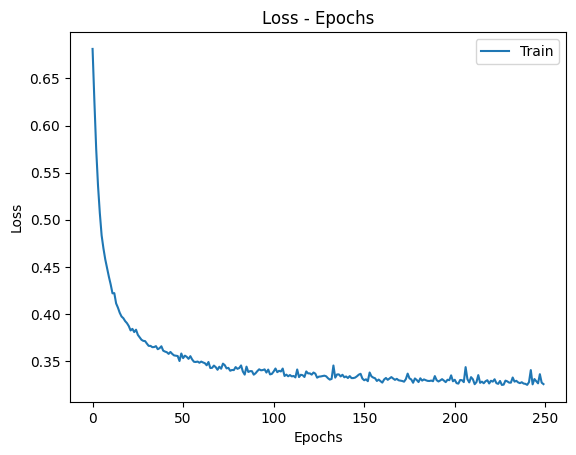

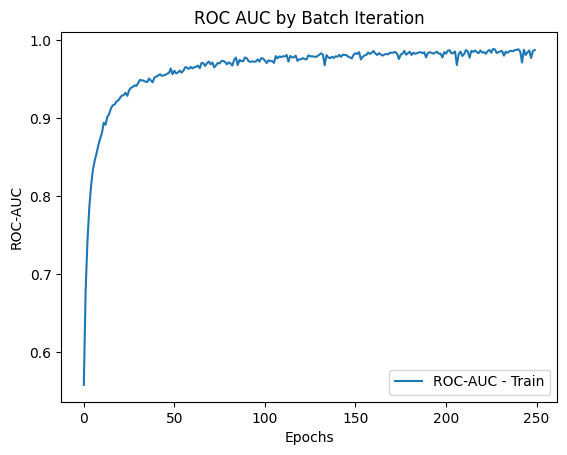

In [ ]:
if TRAIN_MODEL:
  plot_model_metrics(mean_loss_train, mean_auc_train)

In [ ]:
if TRAIN_MODEL:
  torch.save(model.state_dict(), path.join('..','models','final','final_model.pth'))

# Final Evaluation

Let's open the final model:

In [ ]:
FINAL_MODEL_PATH = path.join('..','models','final','final_model.pth')

In [ ]:
# Optimized hyperparameters:
lr = 1.9964928859585677e-05
num_heads = 16
embed_dim = 512
num_hidden_neurons = 64
num_transformer_blocks = 1


image_size = (88,64)
patch_size = (8,8)
in_channels = 1
num_classes = 2
num_hidden_layers = 2
transformer_activation_function = nn.ReLU
feedfoward_activation_function = nn.GELU
dropout = 0.1


model = ViTSD(
              image_size,
              patch_size,
              embed_dim,
              in_channels,
              num_classes,
              num_heads,
              num_hidden_neurons,
              num_hidden_layers,
              transformer_activation_function,
              feedfoward_activation_function,
              num_transformer_blocks,
              device,
              dropout,
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(FINAL_MODEL_PATH))
model.to(device)
model.eval()

ViTSD(
  (spt): ShiftedPatchTokenization(
    (projection): Conv2d(5, 512, kernel_size=(8, 8), stride=(8, 8))
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): ModuleList(
    (0): TransformerLSABlock(
      (mlsa): MultiLocallySelfAttention(
        (mha): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
      )
      (first_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (feedforward): FeedForward(
        (feedforward): ModuleList(
          (0): Linear(in_features=512, out_features=64, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=64, out_features=512, bias=True)
          (4): Identity()
        )
        (final_activation_function): Identity()
      )
      (second_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout_layer): Dropout(p=0.1, inplace=Fals

Let's define the loader function:

In [ ]:
def get_loader_from_dataset(X: np.ndarray, y: np.ndarray, batch_size: int) -> DataLoader:

    """
    
    Creates a DataLoader object from numpy arrays containing images and labels.

    Args:
        X (np.ndarray): numpy array containing the images.
        y (np.ndarray): numpy array containing the labels.
        batch_size (int): size of the batches to use in the DataLoader.

    Returns:
        DataLoader: the created DataLoader object.

    """

    # lists to store the extracted features from each image
    final_images: List[np.ndarray] = []
    percentual_areas: List[np.ndarray] = []
    dmaxs: List[np.ndarray] = []
    dmins: List[np.ndarray] = []
    num_objs: List[np.ndarray] = []

    # extract features from each image and store them in the lists
    for image in X:
        final_image, percentual_area, dmax, dmin, num_obj = get_features(image)

        final_images.append(final_image)
        percentual_areas.append(percentual_area)
        dmaxs.append(dmax)
        dmins.append(dmin)
        num_objs.append(num_obj)

    # convert feature lists to numpy arrays and reshape them
    final_images = np.array(final_images)
    final_images = final_images.reshape(len(final_images), 1, 88, 64)

    percentual_areas = np.array(percentual_areas)
    percentual_areas = percentual_areas.reshape(len(percentual_areas), 1)

    dmaxs = np.array(dmaxs)
    dmaxs = dmaxs.reshape(len(dmaxs), 4)

    dmins = np.array(dmins)
    dmins = dmins.reshape(len(dmins), 4)

    num_objs = np.array(num_objs)
    num_objs = num_objs.reshape(len(num_objs), 4)

    # convert numpy arrays to PyTorch tensors
    final_images = torch.Tensor(final_images)
    percentual_areas = torch.Tensor(percentual_areas)
    dmaxs = torch.Tensor(dmaxs)
    dmins = torch.Tensor(dmins)
    num_objs = torch.Tensor(num_objs)
    targets = torch.Tensor(y)

    # create a TensorDataset object with the tensors and a DataLoader object with the dataset
    data = TensorDataset(final_images, percentual_areas, dmaxs, dmins, num_objs, targets)
    loader = DataLoader(data, batch_size=batch_size)

    return loader


Opening the test set:

  - X_test : Numpy array with images of Test Set.
  - y_test: Numpy array with labels of Test Set:

    - If there is **no** substructure: [1,0]
    - If there if substructure: [0,1]

Once the batch_size is len(y_test) implies that one batch is all test set:

In [ ]:
test_loader = get_loader_from_dataset(X_test, y_test, batch_size = len(y_test))

Making the final evaluation:

In [ ]:
# set model to evaluation mode
model.eval()

# turn off gradients for evaluation
with torch.no_grad():

    # loop over test data
    for final_images, percentual_areas, dmaxs, dmins, num_objs, targets in test_loader:
      
        # move data to device
        final_images, percentual_areas = final_images.to(device), percentual_areas.to(device)
        dmaxs, dmins = dmaxs.to(device), dmins.to(device)
        num_objs, targets = num_objs.to(device), targets.to(device)
        
        # forward pass
        outputs = model(final_images, percentual_areas, dmaxs, dmins, num_objs, device)
        
        prob_preds = outputs.detach().cpu().numpy()
        labels = targets.detach().cpu().numpy()

        # Getting the ROC AUC Score
        preds = [np.argmax(pred) for pred in prob_preds]
        prob_preds = prob_preds[:,1]
        labels = [np.argmax(label) for label in labels]
        roc_auc = roc_auc_score(labels,preds)
        print(f'ROC AUC:{roc_auc}')

    
        break

ROC AUC:0.9562378210540216



Wow, this result is expressive!! **ROC-AUC = 0.956**!! Let's see the other graphs:

In [ ]:
from sklearn import metrics
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(labels, prob_preds)

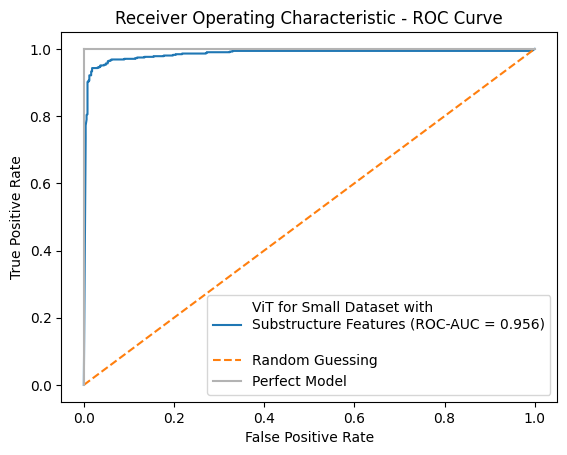

In [ ]:
plt.title('Receiver Operating Characteristic - ROC Curve')
plt.plot(false_positive_rate, true_positive_rate,label=f'ViT for Small Dataset with\nSubstructure Features (ROC-AUC = {roc_auc:0.3})\n')
plt.plot([0, 1], ls="--",label='Random Guessing')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7",label='Perfect Model')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

These results are impressive and show the power of combining classical features (inspired by physical meaning), Machine Learning and Metaheuristic Optimization.

With that, we finish our modeling. Thank you!!